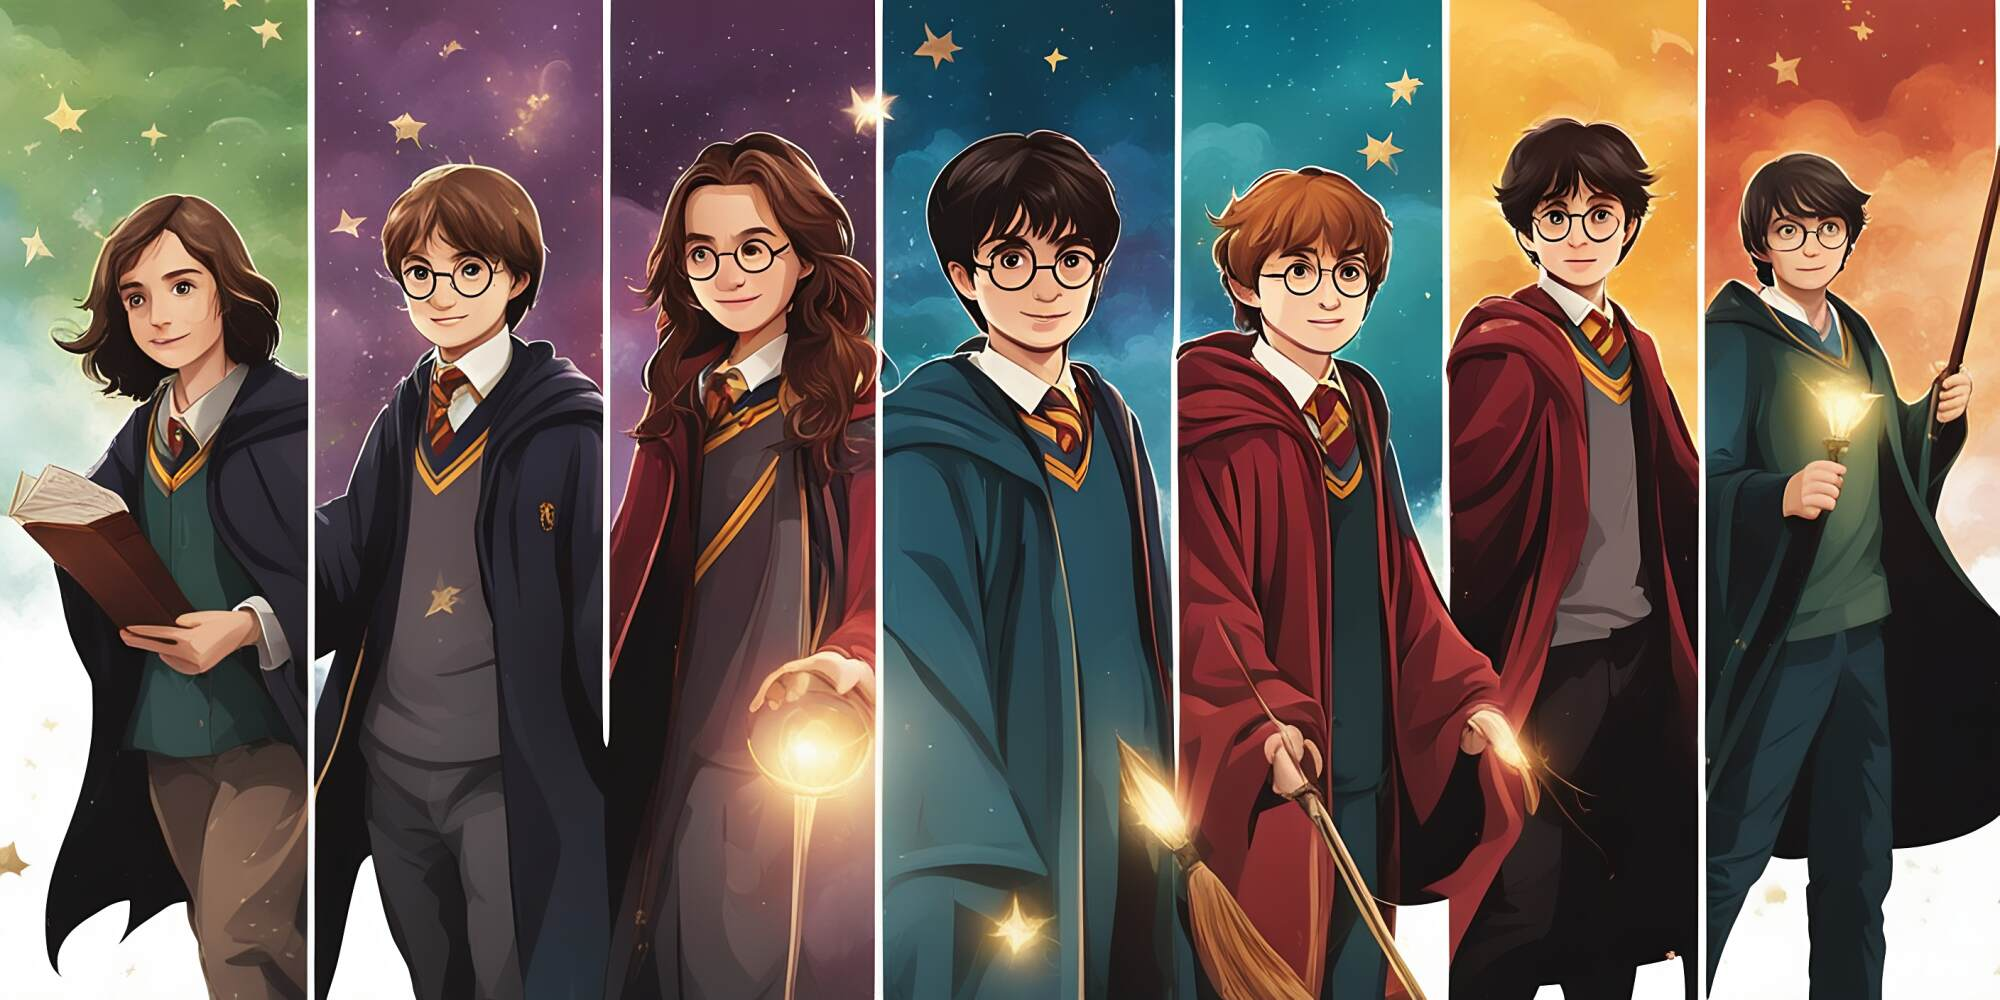

In [1]:
!pip install -qq -U langchain-tavily langchain langgraph duckduckgo-search langchain-core langchain-community langchain-groq faiss-gpu-cu12 sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 60.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 32.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [2]:
# langgraph_multiagent.py
from langchain.tools import tool
from langchain.agents import Tool, initialize_agent
from langchain.agents.agent_types import AgentType
from langchain_core.runnables import Runnable
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, List, Optional
import operator
import os
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
import json
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.messages import AIMessage  # import AIMessage
import torch

In [3]:
os.environ["GROQ_API_KEY"] = "XXX"

## LLM

In [4]:
llm = ChatGroq(
    model_name="qwen/qwen3-32b",
    temperature=0.7
)

## DDG Search

In [5]:
ddg_search = DuckDuckGoSearchResults()

In [6]:
ddg_search_tool = Tool(
    name="DuckDuckGoSearch",
    func=ddg_search.run,  # Uses the standard `.run()` interface
    description=(
        "Use this tool to perform a DuckDuckGo web search and return JSON-formatted results. "
        "Input: a search query string; Output: a JSON array of search results."
    )
)

## 🔄 Node States of Graph

In [7]:
class AgentState(TypedDict):
    topic: str
    research: Optional[str]
    mythology : Optional[str]
    draft: Optional[str]
    critique: Optional[str]
    approved: Optional[bool]
    review: Optional[str]


In [8]:
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Embedding Model

In [10]:
# Initialize BAAI embeddings with GPU support
embedmodel = "BAAI/bge-base-en" # You can also use bge-base for smaller but faster model
model_kwargs = {'device': device}
encode_kwargs = {'batch_size': 128, 'device': device, 'normalize_embeddings': True}

In [11]:
embeddings = HuggingFaceEmbeddings(
    model_name=embedmodel,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

/tmp/ipykernel_36/4252575277.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
2025-07-26 19:08:13.860428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753556894.208676      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753556894.316060      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alrea

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
from transformers import AutoTokenizer, AutoModel

## Reranker Model

In [13]:
# Load BGE reranker model and tokenizer once (outside the function)
reranker_tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-reranker-base")
reranker_model = AutoModel.from_pretrained("BAAI/bge-reranker-base")

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at BAAI/bge-reranker-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
books = "/kaggle/input/harry-potter-books"

In [15]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader

# Initialize the DirectoryLoader
loader = DirectoryLoader(
    path=books,
    glob="**/*.txt",  # Load all .txt files recursively
    loader_cls=TextLoader,  # Use TextLoader for .txt files
    show_progress=True,
    use_multithreading=True
)

In [16]:
documents = loader.load()

100%|██████████| 7/7 [00:00<00:00, 148.20it/s]


## Chunking

In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize the character-based text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Number of characters per chunk
    chunk_overlap=300,  # Overlap between chunks
    separators=["\n\n", "\n", " ", ""],  # Prioritize semantic breaks
)

In [18]:
split_docs = text_splitter.split_documents(documents)

## FAISS Vector DB

In [19]:
vectordb_vectr = FAISS.from_documents(documents=split_docs, embedding=embeddings)

In [20]:
vectordb_vectr.save_local("HPVDb")

In [21]:
from langchain_core.tools import tool

## Retriver as Tool

In [22]:
@tool
def retrieve_context(query,n_docs=5):

    """Retrieve relevant documents from Harry Potter books to answer query"""

    # Step 1: Initial similarity search
    retrieved_docs = vectordb_vectr.similarity_search(query, k=10)  # get more docs for reranking
    pairs = [(query, doc.page_content) for doc in retrieved_docs]

    # Step 2: Format input for BGE reranker (BGE expects "[CLS] query [SEP] passage [SEP]")
    texts = [f"[CLS] {q} [SEP] {p} [SEP]" for q, p in pairs]
    inputs = reranker_tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

    # Step 3: Compute relevance scores
    with torch.no_grad():
        model_output = reranker_model(**inputs)
        scores = model_output.last_hidden_state[:, 0, :]  # CLS token
        scores = torch.nn.functional.normalize(scores, p=2, dim=1)  # normalize if needed
        scores = scores[:, 0]  # Take only the first dim for ranking (simplified relevance proxy)

    # Step 4: Sort documents by score
    reranked = sorted(zip(scores, retrieved_docs), key=lambda x: x[0], reverse=True)
    top_docs = [doc.page_content for _, doc in reranked[:n_docs]]

    return top_docs

## 🧑‍🔬 Researcher Agent


In [23]:

def researcher_node(state: AgentState) -> AgentState:

    agent = create_react_agent(
        model=llm,
        tools=[retrieve_context],
         prompt=(
            "You are a research assistant. "
            "For each query, you MUST use both tools in a logical sequence:\n"
            "1) Use **retrieve_context** to fetch internal or domain-specific context first.\n"
            "Always think through your reasoning, call a tool, observe the result, then respond or call the next tool.\n"
            "Label each action clearly as `Thought:`, `Action:`, `Observation:`."
        )
    )

    # Prepare the prompt
    user_msg = {"role": "user", "content": f"Research this topic in detail: {state['topic']}"}

    ai_content = ""
    for step in agent.stream({"messages": [user_msg]}, stream_mode="values"):
        msg = step["messages"][-1]

        # Capture only if it's an assistant message
        if isinstance(msg, AIMessage):
            ai_content = msg.content
            
    return {**state, "research": ai_content}




## 🧑‍🔬 Mythology Agent


In [24]:
def mythology_node(state: AgentState) -> AgentState:

    agent = create_react_agent(
        model=llm,
        tools=[ddg_search_tool],
          prompt=(
            "You are an expert in **Indian ancient history and mythology**. "
            "Mix and Relate topic and research with Indian Mythology and Harry Potter Universe"
        )
    )

    # Prepare the prompt
    user_msg = {
        "role": "user",
        "content": (
            f"Using the research, topic relate to Indian Mythology:\n\n"
            f"Research : {state['research']}\n\nTopic: {state['topic']}"
        )
    }


    ai_content = ""
    for step in agent.stream({"messages": [user_msg]}, stream_mode="values"):
        msg = step["messages"][-1]
        # Capture only if it's an assistant message
        if isinstance(msg, AIMessage):
            ai_content = msg.content
            
    return {**state, "mythology": ai_content}


## ✍️ Writer Agent


In [25]:

def writer_node(state: AgentState) -> AgentState:
    agent = create_react_agent(
        model=llm,
        tools = [ddg_search_tool],
        prompt=(
            "You are an Article Writer. Use the `DuckDuckGoSearch` to find additional relevant facts, "
            "Mix and Relate topic and research with Indian Mythology and Harry Potter Universe"
            "Follow the ReAct pattern: label each step as `Thought:`, `Action:`, `Observation:`, "
            "then finally `Final Answer:` with your article."
        )

    )

    user_msg = {
        "role": "user",
        "content": (
            f"Using the research below, write a well-structured article on the topic:\n\n"
            f"Review from Critique: {state['review']}\n\n Research : {state['mythology']}\n\nTopic: {state['topic']}"
        )
    }

    ai_content = ""
    for step in agent.stream({"messages": [user_msg]}, stream_mode="values"):
        msg = step["messages"][-1]
        # Capture only if it's an assistant message
        if isinstance(msg, AIMessage):
            ai_content = msg.content

    return {**state, "draft": ai_content}

## 🧑‍⚖️ Critic Agent

In [26]:
def critic_node(state: AgentState) -> AgentState:
    agent = create_react_agent(
        model=llm,
        tools = [],
        prompt=(
            "You are a Critical Reviewer having Knowledge in Both Harry Potter Universe and Indian Mythology."
            "First Give your 'approval' by saying 'Yes' or 'No' by reading the draft."
            "Use Your Intelligence to evaluate the draft and Give your Comments and Reasoning."
        )
    )

    user_msg = {
        "role": "user",
        "content": (
            "Here is the draft article:\n\n"
            f"{state['draft']}\n\n"
            "Please critique it, checking for factual accuracy and clarity."
            "First Give 'approval' by saying 'yes' or 'no' followed by concise reasoning."
        )
    }

    ai_content = ""
    for step in agent.stream({"messages": [user_msg]}, stream_mode="values"):
        msg = step["messages"][-1]
        # Capture only if it's an assistant message
        if isinstance(msg, AIMessage):
            ai_content = msg.content

    
    approved = "yes" in ai_content.lower()

    return {**state, "critique": ai_content, "approved": approved}


## 🔁 Conditional Flow

In [27]:

def check_approval(state: AgentState) -> str:
    if state.get("approved"):
        return "end"
    
    else:
        state["review"] = state["critique"]
        return "mythologist"

## 🌐 Graph Definition


In [28]:

graph = StateGraph(AgentState)

graph.add_node("researcher", researcher_node)
graph.add_node("mythologist", mythology_node)

graph.add_node("writer", writer_node)
graph.add_node("critic", critic_node)

graph.set_entry_point("researcher")

graph.add_edge("researcher", "mythologist")
graph.add_edge("mythologist", "writer")
graph.add_edge("writer", "critic")
graph.add_conditional_edges("critic", check_approval, {
    "end": END,
    "mythologist": "mythologist"  
})


In [29]:
app = graph.compile()

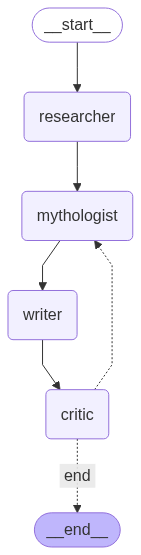

In [30]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## 🚀 Run the Multi-Agent System


In [31]:

output = app.invoke({"topic": "Impact of Professor Severus Snape in Harry Potter's life ?","review": "Write an awesome article on the topic."})


/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
/usr/local/lib/python3.11/dist-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7c59aaf975b0>


## Final Output

In [32]:
from IPython.display import Markdown, display

In [33]:
display(Markdown(f"# 📝 Report\n\n{output['draft']}"))
display(Markdown(f"# 🧐 Critique\n\n{output['critique']}"))

# 📝 Report

**Final Answer:**  

**Severus Snape and the Duality of Heroism: A Dialogue with Indian Mythology**  

Professor Severus Snape’s role in *Harry Potter* is a masterclass in complexity—a figure whose cruelty masks loyalty, whose darkness harbors light. His journey mirrors archetypal Indian mythological characters who embody duality, blurring the lines between hero and villain. By exploring these parallels, we uncover universal themes of redemption, moral ambiguity, and the transformative power of love and duty.  

---

### **1. Snape as Drona: The Guru Who Fulfills and Betrays**  
In the *Mahabharata*, Drona, a revered teacher, trains both Arjuna (a Pandava) and Karna (a Kaurava). His loyalty to Duryodhana forces him to fight against his own students, much like Snape’s conflicted allegiance to Voldemort while secretly aiding Harry. Both characters exemplify the **duality of mentorship**—their harshness is a crucible for growth. Drona teaches Arjuna the *Brahmastra*, a weapon that ultimately kills him, mirroring Snape’s role in imparting skills to Harry that Harry uses to defeat him. Their stories underscore the idea that *true guidance often demands sacrifice and conflict*.  

---

### **2. Snape and Karna: Redemption Through Love**  
Karna, the tragic hero of the *Mahabharata*, is driven by loyalty to Duryodhana and love for his mother, Kunti. His self-sacrifice on the battlefield—despite being betrayed—echoes Snape’s unwavering love for Lily Potter, which becomes his moral compass. Both characters are **flawed yet redeemable**, their heroism arising from a refusal to abandon love in the face of hatred. Karna’s final act—fighting Arjuna to protect Duryodhana’s legacy—parallels Snape’s self-sacrifice to protect Harry, showing how **love can transform even a life stained by regret**.  

---

### **3. Snape as Shiva: The Destroyer Who Protects**  
Lord Shiva, in Hinduism, is the destroyer of evil and the transformer. His fierce forms, like Bhairava, instill fear, yet his compassion heals. Snape’s menacing presence in Hogwarts, coupled with his covert protection of Harry, mirrors this duality. Just as Shiva’s destruction paves the way for renewal, Snape’s ruthless methods (e.g., spying on Voldemort) are necessary for the greater good. Both operate in the shadows, their **harshness masking a deeper commitment to cosmic balance**.  

---

### **4. Snape and Ravana: The Tragic Villain**  
Ravana, the *Ramayana*’s antagonist, is a scholar, king, and devotee of Shiva—yet his obsession with power and love for his sister, Shurpanakha, leads to his downfall. Similarly, Snape’s obsession with Lily’s memory drives his moral ambiguity. Both characters are **products of their desires**, achieving greatness while being undone by their flaws. Their deaths—Ravana slain by Rama, Snape killed by Voldemort—highlight the **inevitability of karma**, where even the most complex villains face consequences.  

---

### **5. Snape’s Legacy: The Mahanatiya (Epic) Paradox**  
Epic archetypes like Shakuni (*Mahabharata*) or Surpanakha (*Ramayana*) sow chaos only to be destroyed by their own machinations. Snape, too, manipulates events to control outcomes but is ultimately consumed by them. His story reflects the *mahanatiya* theme: **evil deeds beget their own undoing**. His manipulation of Harry and Dumbledore’s trust, while strategic, seeds the very redemption he seeks, proving that **intentions and consequences are inextricably linked**.  

---

### **Conclusion: The Universal Hero’s Journey**  
Snape and his mythological counterparts challenge the binary of good and evil. They embody the **human condition**—flawed, conflicted, yet driven by love and duty. As Indian epics teach, true heroism lies not in infallibility but in the courage to confront one’s shadows. Snape’s legacy, like those of Drona, Karna, or Shiva, reminds us that the **path to victory is often paved with paradoxes**.  

In the words of Dumbledore, “It is our choices that show what we truly are.” Snape’s choices, like those of his mythic counterparts, reveal a timeless truth: **the greatest heroes are those who choose redemption over revenge, and growth over hatred**.

# 🧐 Critique

<think>
Okay, so I need to evaluate this draft article that compares Severus Snape to various Indian mythological characters. Let me start by reading through the draft carefully.

The article draws parallels between Snape and Drona, Karna, Shiva, Ravana, and others. The first section compares Snape to Drona, both being mentors who betray their students. The author mentions that Drona teaches Arjuna a weapon that kills him, similar to Snape's role in Harry's defeat. That seems plausible. Drona's story is indeed about conflict of loyalties. 

Next, Snape and Karna are linked through redemption via love. Karna's loyalty to Duryodhana and love for Kunti mirror Snape's love for Lily. Both make sacrifices. I think this is a good point, as Karna is a tragic figure, much like Snape.

Then, comparing Snape to Shiva as the destroyer who protects. Shiva's role as both destroyer and protector fits Snape's dual nature. The idea of Shiva's harshness masking protection is well-made. The mention of Bhairava form is accurate.

The section on Ravana is interesting. The author notes Ravana's intellectual prowess and downfall due to desire. Snape's obsession with Lily leading to his moral ambiguity is a good parallel. However, I should check if the comparison is balanced. Ravana is often seen as a villain, but Snape is more nuanced. The article might be oversimplifying Ravana's character.

The Mahanatiya section references Shakuni and Surpanakha as manipulators destroyed by their own actions. Snape's manipulation of Harry and Dumbledore is compared, but I'm not sure if the term 'Mahanatiya' is correctly used here. It might be better to use 'Mahabharata' or 'epic' terms.

The conclusion ties all these together, emphasizing the universal hero's journey. The use of quotes from Dumbledore adds a nice touch.

Now, checking for factual accuracy. The Mahabharata mentions Drona and Karna correctly. Shiva's roles are accurately described. Ravana's traits are accurate. The term Mahanatiya might be a translation or a typo; perhaps 'Mahanātiya' or 'epic' is more appropriate. Also, ensuring that the comparisons don't oversimplify the mythological characters. For example, Karna is a tragic hero, but Snape's redemption is more about love and duty, which is a valid point.

Clarity is decent, but some parts could be clearer. For example, explaining how Drona's teaching of the Brahmastra leads to his death might need more context. Also, the transition between sections is smooth, but each comparison should be more distinct to avoid confusion.

I think the article makes solid points, but some sections could use more depth or clarification. The main issue is ensuring that the comparisons are well-supported and that the terms used are accurate. Overall, the approval is likely a yes, but with suggestions for improvement.
</think>

**Approval: Yes**  

**Reasoning:**  
The article offers insightful and well-structured parallels between Severus Snape and Indian mythological archetypes, supported by thematic depth and cultural context. Key strengths include:  
1. **Thematic Depth**: The exploration of duality, moral ambiguity, and redemption is nuanced, especially in linking Snape’s loyalty to Lily (love as moral compass) with Karna’s tragic devotion.  
2. **Cultural Accuracy**: References to Drona, Karna, Shiva, and Ravana are factually sound, with accurate portrayals of their roles in the *Mahabharata* and *Ramayana*.  
3. **Originality**: The comparison of Snape to Shiva as a destroyer-protector is particularly creative, highlighting his shadowy yet protective nature.  

**Suggestions for Improvement**:  
- **Clarify Terms**: The term "Mahanatiya" is unclear; it likely refers to "epic" (Sanskrit: *Maha-kāvya*). Replace with "epic paradox" for clarity.  
- **Expand Context**: Briefly explain how Drona’s *Brahmastra* backfires (he is killed by Arjuna’s weapon), as this is pivotal to the analogy.  
- **Balance Comparisons**: While Ravana is intellectually gifted, emphasize his moral flaws (e.g., abducting Sita) to strengthen the Snape-Ravana parallel, which hinges on their shared "flaws leading to downfall."  
- **Avoid Overgeneralization**: Specify that Shiva’s *Bhairava* form is *Nirguna* (formless) in some traditions, contrasting with Snape’s tangible role, to sharpen the metaphor.  

The article is a compelling fusion of Western and Indian mythic archetypes, though minor refinements would enhance precision.